In [ ]:
!pip install scipy
!pip install python-bcb
!pip install workalendar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#links uteis
#https://workalendar.github.io/workalendar/basic.html
#https://colab.research.google.com/drive/1hosZWLh3XBd2PyBQHPqALYqLLyucvwjH#scrollTo=F6ZGDoGSWTHJ
#https://www.codearmo.com/blog/implied-volatility-european-call-python
#https://gist.github.com/Kevin-Jin/4972722d4a3a842be483
from datetime import date
from workalendar.america import Brazil
from datetime import datetime
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize_scalar   
import pandas as pd
import pandas_datareader.data as web
import datetime as dt
from numpy import arange
from pandas import read_csv
from scipy.optimize import curve_fit
from matplotlib import pyplot
from scipy import stats
from bcb import sgs
import seaborn as sns
# Busca a série da SELIC no SGS
selic = sgs.get({'selic':432}, start = '2010-01-01')
selic2 = selic.to_dict()
N = norm.cdf
cal = Brazil()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/TCC Giulia/séries históricas 00-22/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/TCC Giulia/séries históricas 00-22


In [ ]:
b = pd.read_csv('COTAHIST_A{0}_LAST.csv'.format( 2022 ), delimiter=";")
b = b[['data_pregao', 'cod_papel', 'preco_medio', 'data_vencimento', 'preco_exerc', 'cod_bdi', 'espec_papel']]
b = b[(b['espec_papel'].str.contains('PN'))]
b = b[b['cod_papel'].str.contains('PETR')]
b = b[b['cod_bdi'] == 2]
b = b.set_index('data_pregao')
b = b[['preco_medio']]
r = b.to_dict()

In [ ]:
a = pd.read_csv('COTAHIST_A{0}_LAST.csv'.format( 2022 ), delimiter=";")
a = a[['data_pregao', 'cod_papel', 'preco_medio', 'data_vencimento', 'preco_exerc', 'cod_bdi', 'espec_papel']]
a = a[a['espec_papel'].str.contains('PN')]
a = a[a['cod_papel'].str.contains('PETR')]
a = a[a['cod_bdi'] != 2]

In [ ]:
a.head(3)

,data_pregao,cod_papel,preco_medio,data_vencimento,preco_exerc,cod_bdi,espec_papel
289,2010-01-04 00:00:00,PETRA28,9.29,2010-01-18 00:00:00,27.83,78,PN
290,2010-01-04 00:00:00,PETRA30,7.58,2010-01-18 00:00:00,29.66,78,PN
291,2010-01-04 00:00:00,PETRA32,6.18,2010-01-18 00:00:00,31.07,78,PN


In [ ]:
def tryspot(x, r):
    try:
        spot = r['preco_medio'][x['data_pregao']]
    except:
        return(0)
    return(spot)
a['spot'] = a.apply(lambda x: tryspot(x, r), axis=1)
a = a[a['spot']>0]


In [ ]:
def BS_CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * N(d1) - K * np.exp(-r*T)* N(d2)

def BS_PUT(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma* np.sqrt(T)
    return K*np.exp(-r*T)*N(-d2) - S*N(-d1)    
    

def implied_vol(opt_value, S, K, T, r, type_='call'):
    
    def call_obj(sigma):
        return abs(BS_CALL(S, K, T, r, sigma) - opt_value)
    
    def put_obj(sigma):
        return abs(BS_PUT(S, K, T, r, sigma) - opt_value)
    
    if type_ == 'call':
        res = minimize_scalar(call_obj, bounds=(0.01,3), method='bounded')
        return res.x
    elif type_ == 'put':
        res = minimize_scalar(put_obj, bounds=(0.01,3),
                              method='bounded')
        return res.x
    else:
        raise ValueError("type_ must be 'put' or 'call'")
        
def objective(x, a, b, rho, sigma, m):
	return a + b*(rho*(x-m)+ np.sqrt((x-m)**2 + sigma**2))

#def objective(x, a, b, c):
#    return a * x + b * x**2 + c
def my_function(x):
  return list( dict.fromkeys(x) )

In [ ]:
a['selic'] = a['data_pregao'].apply(lambda x: selic2['selic'][datetime.strptime(x, "%Y-%m-%d %H:%M:%S")]/100)


#selic2['selic'][datetime.strptime(x['data_pregao'], "%Y-%m-%d %H:%M:%S")]/100

In [ ]:
#a['volatilidade'] = a.apply(lambda x: implied_vol(x['spot'],x['preco_exerc'], x['dias_ate_vencimento'], selic2['selic'][datetime.strptime(x['data_pregao'], "%Y-%m-%d %H:%M:%S")], 1, x['preco_medio']), axis=1)
a["dias_ate_vencimento"] = a.apply(lambda x: cal.get_working_days_delta(datetime.strptime(x["data_pregao"], "%Y-%m-%d %H:%M:%S"), datetime.strptime(x["data_vencimento"], "%Y-%m-%d %H:%M:%S")), axis=1)
a['volatilidade'] = a.apply(lambda x: implied_vol(x['preco_medio'], x['spot'], x['preco_exerc'], x['dias_ate_vencimento']/252, selic2['selic'][datetime.strptime(x['data_pregao'], "%Y-%m-%d %H:%M:%S")]/100, 'call') if x['cod_bdi'] == 78 else implied_vol(x['preco_medio'], x['spot'], x['preco_exerc'], x['dias_ate_vencimento']/252, selic2['selic'][datetime.strptime(x['data_pregao'], "%Y-%m-%d %H:%M:%S")]/100, 'put'), axis=1)
#a['NS'] = a['preco_exerc']/(a['spot']*(1+a['selic'])^(a["dias_ate_vencimento"]/252))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


In [ ]:
a.to_csv('Volatilidades_PETR_2911_2010.csv')

In [ ]:
a = pd.read_csv('Volatilidades_preco_medio_vale2_newbound.csv')

In [ ]:
a

,Unnamed: 0,data_pregao,cod_papel,preco_medio,data_vencimento,preco_exerc,cod_bdi,espec_papel,spot,selic,dias_ate_vencimento,volatilidade
0,848,2015-01-02 00:00:00,VALEA15,3.16,2015-01-19 00:00:00,15.85,78,PNA N1,18.80,0.1175,11,0.683186
1,849,2015-01-02 00:00:00,VALEA17,2.19,2015-01-19 00:00:00,16.85,78,PNA N1,18.80,0.1175,11,0.531006
2,850,2015-01-02 00:00:00,VALEA18,1.32,2015-01-19 00:00:00,17.85,78,PNA N1,18.80,0.1175,11,0.443623
3,851,2015-01-02 00:00:00,VALEA19,0.48,2015-01-19 00:00:00,19.10,78,PNA N1,18.80,0.1175,11,0.365389
4,852,2015-01-02 00:00:00,VALEA20,0.24,2015-01-19 00:00:00,19.85,78,PNA N1,18.80,0.1175,11,0.372679
...,...,...,...,...,...,...,...,...,...,...,...,...
120597,1074407,2017-08-11 00:00:00,VALEU88,0.72,2017-09-18 00:00:00,27.84,82,PNA N1,28.75,0.0925,25,0.343320
120598,1074408,2017-08-11 00:00:00,VALEU9,1.65,2017-09-18 00:00:00,29.84,82,PNA N1,28.75,0.0925,25,0.326903
120599,1074409,2017-08-11 00:00:00,VALEV13,4.42,2017-10-16 00:00:00,33.34,82,PNA N1,28.75,0.0925,44,0.324405
120600,1074410,2017-08-11 00:00:00,VALEW84,0.47,2017-11-21 00:00:00,23.34,82,PNA N1,28.75,0.0925,68,0.441343


In [ ]:
a['NS'] = np.log(a['preco_exerc']/(a['spot']*(1+a['selic'])**(a["dias_ate_vencimento"]/252)))

In [ ]:
a

,Unnamed: 0,data_pregao,cod_papel,preco_medio,data_vencimento,preco_exerc,cod_bdi,espec_papel,spot,selic,dias_ate_vencimento,volatilidade,NS
0,848,2015-01-02 00:00:00,VALEA15,3.16,2015-01-19 00:00:00,15.85,78,PNA N1,18.80,0.1175,11,0.683186,-0.175537
1,849,2015-01-02 00:00:00,VALEA17,2.19,2015-01-19 00:00:00,16.85,78,PNA N1,18.80,0.1175,11,0.531006,-0.114356
2,850,2015-01-02 00:00:00,VALEA18,1.32,2015-01-19 00:00:00,17.85,78,PNA N1,18.80,0.1175,11,0.443623,-0.056703
3,851,2015-01-02 00:00:00,VALEA19,0.48,2015-01-19 00:00:00,19.10,78,PNA N1,18.80,0.1175,11,0.365389,0.010982
4,852,2015-01-02 00:00:00,VALEA20,0.24,2015-01-19 00:00:00,19.85,78,PNA N1,18.80,0.1175,11,0.372679,0.049498
...,...,...,...,...,...,...,...,...,...,...,...,...,...
120597,1074407,2017-08-11 00:00:00,VALEU88,0.72,2017-09-18 00:00:00,27.84,82,PNA N1,28.75,0.0925,25,0.343320,-0.040941
120598,1074408,2017-08-11 00:00:00,VALEU9,1.65,2017-09-18 00:00:00,29.84,82,PNA N1,28.75,0.0925,25,0.326903,0.028435
120599,1074409,2017-08-11 00:00:00,VALEV13,4.42,2017-10-16 00:00:00,33.34,82,PNA N1,28.75,0.0925,44,0.324405,0.132673
120600,1074410,2017-08-11 00:00:00,VALEW84,0.47,2017-11-21 00:00:00,23.34,82,PNA N1,28.75,0.0925,68,0.441343,-0.232342


In [ ]:
volatilities = a[['cod_papel', 'NS', 'volatilidade', 'dias_ate_vencimento', 'data_pregao']]

volatilities = volatilities.reset_index()
volatilities = volatilities[['cod_papel','NS', 'volatilidade', 'dias_ate_vencimento', 'data_pregao']]
volatilities.columns = ['Ticker', 'Normalized Strike', 'Volatility', 'Days to Maturity', 'Data']
volatilities

,Ticker,Normalized Strike,Volatility,Days to Maturity,Data
0,VALEA15,-0.175537,0.683186,11,2015-01-02 00:00:00
1,VALEA17,-0.114356,0.531006,11,2015-01-02 00:00:00
2,VALEA18,-0.056703,0.443623,11,2015-01-02 00:00:00
3,VALEA19,0.010982,0.365389,11,2015-01-02 00:00:00
4,VALEA20,0.049498,0.372679,11,2015-01-02 00:00:00
...,...,...,...,...,...
120597,VALEU88,-0.040941,0.343320,25,2017-08-11 00:00:00
120598,VALEU9,0.028435,0.326903,25,2017-08-11 00:00:00
120599,VALEV13,0.132673,0.324405,44,2017-08-11 00:00:00
120600,VALEW84,-0.232342,0.441343,68,2017-08-11 00:00:00


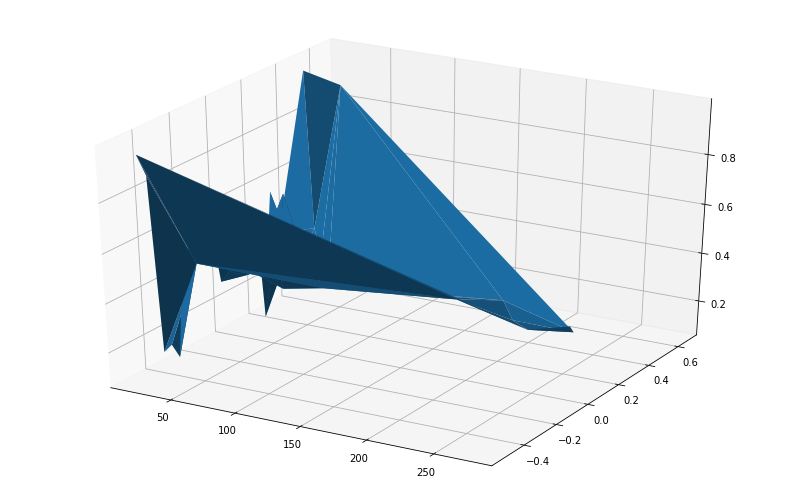

In [ ]:
import matplotlib.pyplot as plt

vol2 = volatilities[volatilities['Data']== '2015-03-20 00:00:00']
fig = plt.figure(figsize =(14, 9)) 
ax = plt.axes(projection ='3d') 
ax.plot_trisurf(vol2['Days to Maturity'], vol2['Normalized Strike'], vol2['Volatility']) 

In [ ]:
a['variancia'] = a['volatilidade']**2


In [ ]:
#teste
c = a[a['data_pregao']== '2015-06-20 00:00:00']
tenors = my_function(c['dias_ate_vencimento'].to_list())
tenors.sort()
c = c[c['NS'] < 0.3]
c = c[c['NS'] > -0.4]
c = c[c['variancia'] < 0.85] 
for tenor in tenors:
    d = c[c['dias_ate_vencimento']== tenor]
    if(len(d['data_pregao'].to_list())>5):
        y = d['variancia'].to_list()
        x = d['NS'].to_list()
        if(len(x)>6):
            try:                
                popt, _ = curve_fit(objective, x, y, maxfev=5000, p0 = (0.015, 0.05, -0.3, 0.1, 0.1), bounds=((0, 0, -1, 0, min(x)), (np.inf, 2/tenor, 1, 10, max(x))))
                alpha, beta, rho, sigma, m = popt
            except:
                try:
                    popt, _ = curve_fit(objective, x, y, maxfev=20000, p0 = (0.015, 0.05, -0.3, 0.1, 0.1), bounds=((0, 0, -1, 0, min(x)), (np.inf, 2/tenor, 1, 10, max(x))))
                    alpha, beta, rho, sigma, m = popt
                except:
                    popt, _ = curve_fit(objective, x, y, maxfev=1000000, p0 = (0.015, 0.05, -0.3, 0.1, 0.1), bounds=((0, 0, -1, 0, min(x)), (np.inf, 2/tenor, 1, 10, max(x))))
                    alpha, beta, rho, sigma, m = popt
            break
print(alpha, beta, rho, sigma, m)
print((alpha + beta*sigma * np.sqrt(1 - rho**2)) )
print(alpha/sigma)
pyplot.scatter(x, y)
# define a sequence of inputs between the smallest and largest known inputs
x_line = arange(min(x), max(x), 0.01)
# calculate the output for the range
y_line = objective(x_line, alpha, beta, rho, sigma, m)
# create a line plot for the mapping function
pyplot.plot(x_line, y_line, '--', color='red', label='Fitted SVI Model to Market Data')
plt.title("Fitting do modelo SVI para 23Jul2015 - VALE3")
plt.ylabel("Volatilidade")
plt.xlabel("Log-Forward Moneyness")
pyplot.show()

NameError: ignored

In [ ]:
mylist = my_function(a['data_pregao'].to_list()[0:1000])
lista_parâmetros = []
matriz_tenors = []
lista_tenor = []
lista_tenors_final =[]
last_popt = []
date_list = []
for day in mylist:
    lista_tenor = []
    lista_param_tenor = []
    c = a[a['data_pregao']== day]
    c = c[c['NS'] < 0.5]
    c = c[c['NS'] > -0.4]
    c = c[c['variancia'] < 0.85]
    tenors = my_function(c['dias_ate_vencimento'].to_list())
    tenors.sort()
    count = 0
    for tenor in tenors:
        d = c[c['dias_ate_vencimento']== tenor]
        if(len(d['data_pregao'].to_list())>5):
            y = d['variancia'].to_list()
            x = d['NS'].to_list()
            if(len(x)>6):
                try:
                    popt, _ = curve_fit(objective, x, y, maxfev=5000, bounds=((0, 0, -1, 0, min(x)), (np.inf, 2/tenor, 1, 10, max(x))))
                except:
                    try:
                        popt, _ = curve_fit(objective, x, y, maxfev=20000, bounds=((0, 0, -1, 0, min(x)), (np.inf, 2/tenor, 1, 10, max(x))))
                    except:
                        try:
                          popt, _ = curve_fit(objective, x, y, maxfev=1000000, bounds=((0, 0, -1, 0, min(x)), (np.inf, 2/tenor, 1, 10, max(x))))
                        except:
                          print('erro aqui')
                          popt = last_popt
                try:
                  alpha, beta, rho, sigma, m = popt
                except:
                  pass
                lista_param_tenor.append([alpha, beta, rho, sigma, m])
                lista_tenor.append(tenor)
                last_popt = popt
            else:
              alpha, beta, rho, sigma, m = last_popt
              lista_param_tenor.append([alpha, beta, rho, sigma, m])
              lista_tenor.append(tenor)
            if count == 0:
              date_list.append(day)
            count += 1 
            
    lista_tenors_final.append(lista_tenor)
    lista_parâmetros.append(lista_param_tenor)


In [ ]:
new_dict = {'params': lista_parâmetros, 'tenors': lista_tenors_final, 'data_pregao': date_list}
dataframenovo = pd.DataFrame.from_dict(new_dict)
dataframenovo.to_csv("Salvando_listas_parm_1911_vale2_newbound.csv")

In [ ]:
interpolacao = [7, 14, 21,  30, 60]
lista_alpha = []
lista_beta = []
lista_rho = []
lista_sigma = []
lista_m = []
lista_a_7dias = []
lista_b_7dias=[]
lista_rho_7dias=[]
lista_sigma_7dias=[]
lista_m_7dias=[]

lista_a_14dias = []
lista_b_14dias=[]
lista_rho_14dias=[]
lista_sigma_14dias=[]
lista_m_14dias=[]

lista_a_21dias = []
lista_b_21dias=[]
lista_rho_21dias=[]
lista_sigma_21dias=[]
lista_m_21dias=[]

lista_a_30dias = []
lista_b_30dias=[]
lista_rho_30dias=[]
lista_sigma_30dias=[]
lista_m_30dias=[]

lista_a_60dias = []
lista_b_60dias=[]
lista_rho_60dias=[]
lista_sigma_60dias=[]
lista_m_60dias=[]


new_data = []
for i in range(len(lista_parâmetros)):
    lista_alpha = []
    lista_beta = []
    lista_rho = []
    lista_sigma = []
    lista_m = []
    for lista in lista_parâmetros[i]:
        lista_alpha.append(lista[0])
        lista_beta.append(lista[1])
        lista_rho.append(lista[2])
        lista_sigma.append(lista[3])
        lista_m.append(lista[4])
    try:
        lista_a_interpolada = np.interp(interpolacao, lista_tenors_final[i], lista_alpha)
        lista_b_interpolada = np.interp(interpolacao, lista_tenors_final[i], lista_beta)
        lista_rho_interpolada = np.interp(interpolacao, lista_tenors_final[i], lista_rho)
        lista_sigma_interpolada = np.interp(interpolacao, lista_tenors_final[i], lista_sigma)
        lista_m_interpolada = np.interp(interpolacao, lista_tenors_final[i], lista_m)
        lista_a_7dias.append(lista_a_interpolada[0])
        lista_b_7dias.append(lista_b_interpolada[0])
        lista_rho_7dias.append(lista_rho_interpolada[0])
        lista_sigma_7dias.append(lista_sigma_interpolada[0])
        lista_m_7dias.append(lista_m_interpolada[0])

        lista_a_14dias.append(lista_a_interpolada[1])
        lista_b_14dias.append(lista_b_interpolada[1])
        lista_rho_14dias.append(lista_rho_interpolada[1])
        lista_sigma_14dias.append(lista_sigma_interpolada[1])
        lista_m_14dias.append(lista_m_interpolada[1])

        lista_a_21dias.append(lista_a_interpolada[2])
        lista_b_21dias.append(lista_b_interpolada[2])
        lista_rho_21dias.append(lista_rho_interpolada[2])
        lista_sigma_21dias.append(lista_sigma_interpolada[2])
        lista_m_21dias.append(lista_m_interpolada[2])

        lista_a_30dias.append(lista_a_interpolada[3])
        lista_b_30dias.append(lista_b_interpolada[3])
        lista_rho_30dias.append(lista_rho_interpolada[3])
        lista_sigma_30dias.append(lista_sigma_interpolada[3])
        lista_m_30dias.append(lista_m_interpolada[3])

        lista_a_60dias.append(lista_a_interpolada[4])
        lista_b_60dias.append(lista_b_interpolada[4])
        lista_rho_60dias.append(lista_rho_interpolada[4])
        lista_sigma_60dias.append(lista_sigma_interpolada[4])
        lista_m_60dias.append(lista_m_interpolada[4])


        new_data.append(mylist[i])
    except:
        pass
    

Text(0.5, 1.0, 'Parameter a')

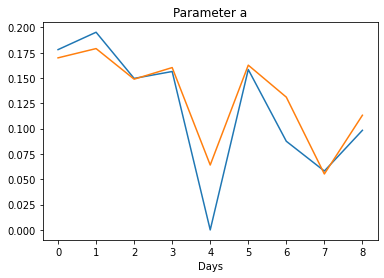

In [ ]:
import matplotlib.pyplot as plt
#plt.plot(lista_a_7dias)

#plt.xlabel('Days')
#plt.title('Parameter a')

plt.plot(lista_a_7dias)
plt.plot(lista_a_14dias)
plt.xlabel('Days')
plt.title('Parameter a')


Text(0.5, 1.0, 'Parameter rho')

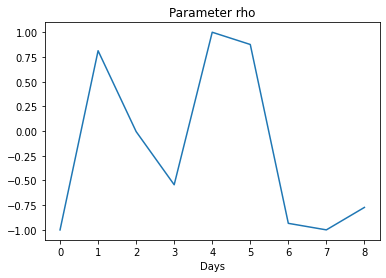

In [ ]:

plt.plot(lista_rho_7dias)

plt.xlabel('Days')
plt.title('Parameter rho')

Text(0.5, 1.0, 'Parameter b')

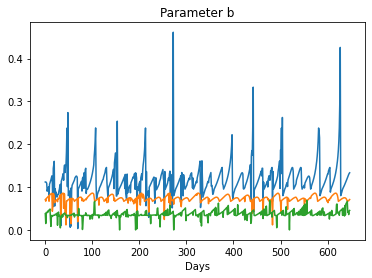

In [ ]:
plt.plot(lista_b_21dias)
plt.plot(lista_b_30dias)
plt.plot(lista_b_60dias)
plt.xlabel('Days')
plt.title('Parameter b')

Text(0.5, 1.0, 'Parameter m')

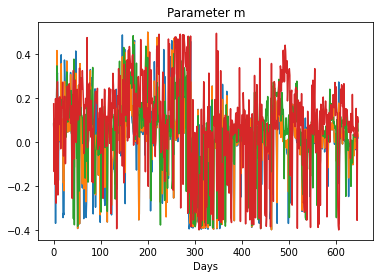

In [ ]:
plt.plot(lista_m_7dias)
plt.plot(lista_m_14dias)
plt.plot(lista_m_30dias)
plt.plot(lista_m_60dias)
plt.xlabel('Days')
plt.title('Parameter m')

Text(0.5, 1.0, 'Parameter sigma')

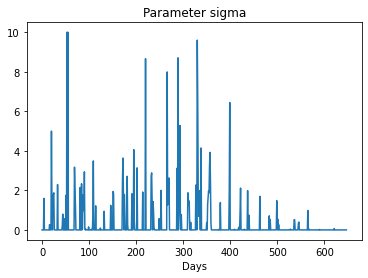

In [ ]:
plt.plot(lista_sigma_7dias)

plt.xlabel('Days')
plt.title('Parameter sigma')

In [ ]:
import ast
res = ast.literal_eval(ini_list)

In [ ]:
dict_to_save = {'alpha7dias': lista_a_7dias,
                'beta7dias': lista_b_7dias,
                'rho7dias': lista_rho_7dias,
                'sigma7dias': lista_sigma_7dias,
                'm7dias': lista_m_7dias,

                'alpha14dias': lista_a_14dias,
                'beta14dias': lista_b_14dias,
                'rho14dias': lista_rho_14dias,
                'sigma14dias': lista_sigma_14dias,
                'm14dias': lista_m_14dias,
                
                'alpha21dias': lista_a_21dias,
                'beta21dias': lista_b_21dias,
                'rho21dias': lista_rho_21dias,
                'sigma21dias': lista_sigma_21dias,
                'm21dias': lista_m_21dias,
                
                'alpha30dias': lista_a_30dias,
                'beta30dias': lista_b_30dias,
                'rho30dias': lista_rho_30dias,
                'sigma30dias': lista_sigma_30dias,
                'm30dias': lista_m_30dias,
                
                'alpha60dias': lista_a_60dias,
                'beta60dias': lista_b_60dias,
                'rho60dias': lista_rho_60dias,
                'sigma60dias': lista_sigma_60dias,
                'm60dias': lista_m_60dias,
                
}

In [ ]:
dados_interpolados = pd.DataFrame.from_dict(dict_to_save)
dados_interpolados.to_csv("listas_interpoladas_1911_vale2_newbound.csv")

In [ ]:
df_recupera = pd.read_csv("Salvando233.csv")
lista_parâmetros = df_recupera['params'].to_list()
lista_tenors_final = df_recupera['tenors'].to_list()
datas_pregao = df_recupera['data_pregao'].to_list()

FileNotFoundError: ignored

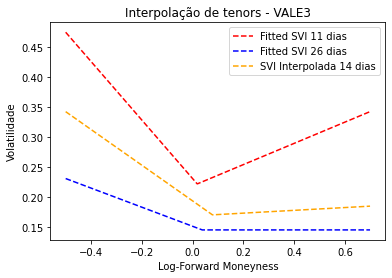

In [ ]:
a1 = lista_alpha[0]
b1 = lista_beta[0]
r1 = lista_rho[0]
s1 = lista_sigma[0]
m1 = lista_m[0]

a14 = lista_a_14dias[0]
b14 = lista_b_14dias[0]
r14 = lista_rho_14dias[0]
s14 = lista_sigma_14dias[0]
m14= lista_m_14dias[0]

a2 = lista_alpha[1]
b2 = lista_beta[1]
r2 = lista_rho[1]
s2 = lista_sigma[1]
m2 = lista_m[1]


x_line = np.arange(-0.5, 0.7, 0.001)

y_line = objective(x_line, a1, b1, r1, s1, m1)
y_line2 = objective(x_line, a2, b2, r2, s2, m2)
y_line3 = objective(x_line, a14, b14, r14, s14, m14)
plt.plot(x_line, y_line, '--', color='red', label = 'Fitted SVI 11 dias')
plt.plot(x_line, y_line2, '--', color='blue', label ='Fitted SVI 26 dias')
plt.plot(x_line, y_line3, '--', color='orange', label='SVI Interpolada 14 dias')

plt.title("Interpolação de tenors - VALE3")
plt.ylabel("Volatilidade")
plt.xlabel("Log-Forward Moneyness")
plt.legend()

plt.show()

In [ ]:
lista_tenors_final[0]

[11, 26, 51, 264]